The above header is for creating a nicely-formatted `.html` and `.pdf` documents using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html` and `.pdf` versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-32.ipynb 

Other useful information about this notebook:

- Filename: `dissipation-theory--Study-32.ipynb`
- Continued from: `dissipation-theory--Study-31.ipynb`
- Continued to: `dissipation-theory--Study-33.ipynb`

# Preliminaries

In [2]:
import numpy as np
import warnings
from numpy import inf
from dissipationtheory.constants import ureg, epsilon0, qe
from mpl_toolkits import mplot3d

In [3]:
%matplotlib inline
import matplotlib.pylab as plt

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 3.25, 3.5

# Set parameters

In [269]:
Ntheta = 80
Nphi = 160

r = ureg.Quantity(30, 'nm')
h = ureg.Quantity(3000, 'nm')

# Set up voltage test-point vectors

Going forward, convert radius and height to unitless numbers.

In [270]:
r = r.to('nm').magnitude
h = h.to('nm').magnitude

Create a list of $\phi$ and $\theta$ points.

In [271]:
phi = np.linspace(start=0, stop=2*np.pi, endpoint=False, num=Nphi)
theta = np.linspace(start=0, stop=np.pi, endpoint=True, num=Ntheta)
q = np.ones(Ntheta * Nphi)

In [272]:
(phi.shape, theta.shape)

((160,), (80,))

Create outer-product arrays and flatten them.

In [273]:
phiBig = np.outer(phi, np.ones_like(theta)).flatten()
thetaBig = np.outer(np.ones_like(phi), theta).flatten()

In [274]:
(phiBig.shape, thetaBig.shape)

((12800,), (12800,))

Create a set of 3D points covering the sphere.

In [275]:
rk = np.array([[r * np.sin(theta) * np.cos(phi),
                r * np.sin(theta) * np.sin(phi),
                h + r + r * np.cos(theta)] 
               for phi, theta in zip(phiBig, thetaBig)])

Plot the points to confirm we've set up everything correctly.  This plot looks reasonable for $(N_\theta, N_\phi)$ = (10, 20) points.

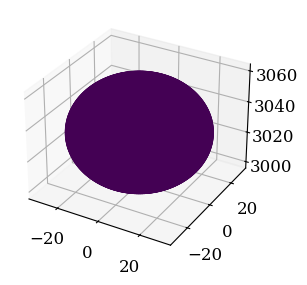

In [276]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(rk[:,0], rk[:,1], rk[:,2], c=q);

# Solve the inverse problem

Create arrays of the distances, in $x$, $y$, and $z$, between the voltage test points.

In [277]:
Idk = np.ones_like(rk[:,0])

In [278]:
dx = np.outer(Idk, rk[:,0].T) - np.outer(rk[:,0], Idk.T)
dy = np.outer(Idk, rk[:,1].T) - np.outer(rk[:,1], Idk.T)
dz = np.outer(Idk, rk[:,2].T) - np.outer(rk[:,2], Idk.T)

Create the Green's function matrix $R$, proportional to $1/r$ with $r$ the distances between the points.  Along the diagonal, we get $\infty$.  Set these diagonal elements to zero by replacing $\infty$ with 0.

In [279]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    R = 1.43996 * (1/np.sqrt(dx * dx + dy * dy + dz * dz)) 

R[R == inf] = 0

Invert the $R$ matrix using singular value decomposition.  This step can take many minutes with thousands of voltage-test point.

In [280]:
U, S, VT = np.linalg.svd(R, full_matrices=False)
Sinv = np.diag(np.power(S, -1)) 
Rinv = np.dot(np.dot(VT.T, Sinv), U.T)

Compute the charge at east test-point.  Sum over the charges and multiply by a constant to get the capacitance.

In [281]:
q = np.dot(Rinv, np.ones(Ntheta * Nphi))  # in units of qe
C = 0.16022 * q.sum()                     # in units of aF

# Evaluate the calculated capacitance

The capacitance is

In [285]:
C

3.041636052266915

which is in poor agreement with the expected value of

In [286]:
C_calc = (4 * np.pi * epsilon0 * ureg.Quantity(r, 'nm')).to('aF').magnitude
C_calc

3.337950166343611

Compute a percentage error

In [284]:
print("relative error = {:0.3f} % for {:d} points".format(
    100 * (C_calc - C)/C_calc, len(rk)))

relative error = 8.877 % for 12800 points


# Summary

I ran two simulations.  The first one took a few minutes, the second one too *many* minutes.  Relative errors

| $N_\theta$ | $N_\phi$ | $N_{r_k}$ | percent error |
| ------| --- | ------ | ------------- |
| 40    | 80  | 3200   |  -4.89        |
| 80    | 160 | 12800  | +8.877        |

# Discussion

The error should get smaller, not larger, as the number of voltage-test points increases.  

I am worried that this divergence is caused by the standard sphere parametrization employed here.  The standard parametrization has an area element, $R^2 \sin{\theta}$,  that goes to zero at the poles, $\theta =0$ and $\theta = \pi$.  The surface charge *density* should be be uniform.  This means that very large charges are needed at poles where the patch area goes to zero.

For the boundary point method employed here to be practical, it needs to work with a few percent error with only a few thousand points.  Perhaps a better sphere parameterization would lead to improved results.  It would be better to have a constant-area parameterization. 

# Follow up

Try a constant-area parameterization!  Do this using points chosen *at random*.

Reset the simulation parameters.

In [4]:
Ntheta = 20
Nphi = 40

r = ureg.Quantity(30, 'nm')
h = ureg.Quantity(0, 'nm')

Choose the $\phi$ and $\theta$ points *at random*.

In [5]:
r = r.to('nm').magnitude
h = h.to('nm').magnitude

phi = np.random.uniform(low=0, high=2*np.pi, size=Nphi)
theta = np.random.uniform(low=0, high=np.pi, size=Ntheta)

q = np.ones(Ntheta * Nphi)
len(phi) * len(theta)

800

Create a set of points covering the sphere.

In [6]:
phiBig = np.outer(phi, np.ones_like(theta)).flatten()
thetaBig = np.outer(np.ones_like(phi), theta).flatten()

rk = np.array([[r * np.sin(theta) * np.cos(phi),
                r * np.sin(theta) * np.sin(phi),
                h + r + r * np.cos(theta)] 
               for phi, theta in zip(phiBig, thetaBig)])

Plot the points.

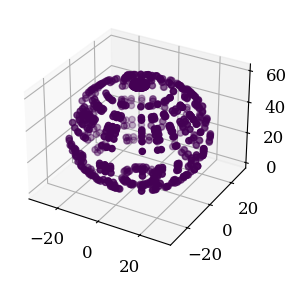

In [7]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(rk[:,0], rk[:,1], rk[:,2], c=q);

The points are still correlated.

A better way to get points randomly distributed on a sphere is outlined at [stackexchange](https://math.stackexchange.com/questions/1585975/how-to-generate-random-points-on-a-sphere) and at [mathworld](https://mathworld.wolfram.com/SpherePointPicking.html).  Both posts discuss a method involving Gaussian random variables.  Impliment this method below.

In [8]:
Nrk = 3200
rk = np.zeros((Nrk, 3))
q = np.ones(Nrk)
for index in np.arange(Nrk):
    r_trial = np.array(
        [np.random.normal(0,1),
         np.random.normal(0,1),
         np.random.normal(0,1)])
    rk[index] = r * r_trial / np.sqrt(np.dot(r_trial, r_trial))

Plot the points.

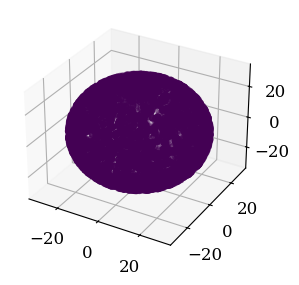

In [9]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(rk[:,0], rk[:,1], rk[:,2], c=q);

Confirm that they all lie on the sphere.

In [10]:
r_array = np.sqrt(rk[:,0] * rk[:,0] + rk[:,1] * rk[:,1] + rk[:,2] * rk[:,2])
(r_array.mean(), r_array.std())

(30.0, 3.060029239235045e-15)

Now compute the capacitance.

In [11]:
Idk = np.ones_like(rk[:,0])

dx = np.outer(Idk, rk[:,0].T) - np.outer(rk[:,0], Idk.T)
dy = np.outer(Idk, rk[:,1].T) - np.outer(rk[:,1], Idk.T)
dz = np.outer(Idk, rk[:,2].T) - np.outer(rk[:,2], Idk.T)
Rsep = np.sqrt(dx * dx + dy * dy + dz * dz)

with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    R = 1.43996 * (1/Rsep) 

R[R == inf] = 0

U, S, VT = np.linalg.svd(R, full_matrices=False)
Sinv = np.diag(np.power(S, -1)) 
Rinv = np.dot(np.dot(VT.T, Sinv), U.T)

q = np.dot(Rinv, np.ones(Nrk))  # in units of qe
C = 0.16022 * q.sum()           # in units of aF

The expected capacitance is

In [12]:
C_calc = (4 * np.pi * epsilon0 * ureg.Quantity(r, 'nm')).to('aF').magnitude
C_calc

3.337950166343611

Check the capacitance.

In [13]:
print("relative error = {:0.3f} % for {:d} points".format(
    100 * (C_calc - C)/C_calc, len(rk)))

relative error = -3.494 % for 3200 points


# Follow-up discussion

I am able to get a lower relative error using *randomly chosen* points.  Using the standard parametrization with 3200 points, the sphere capacitance error was $-4.9$% .  With 3200 randomly-chosen points, I ran a couple of trials.  The capitance error was $0.22$%, $-9.4$%, $-9.8$%, $-1.1$%, and $-2.3$, $-4.2$%, $-3.5$%, and $-4.3$%.  

With randomly chosen points, the points are not concentrated at the poles like in the standard parametrization.  I hypothesize that this is why the accuracy can be better than in the standard parameterization.

I suspect that the lowest error was for points that were, by chance, well separated.  It might be possible to "ripen" the randomly chosen points to get a more even distance distribution ...

# Continue

Examine if there is a correlation beween the capacitance error and the condition number of the $R$ matrix.

In [147]:
def calc(Nrk):

    rk = np.zeros((Nrk, 3))
    q = np.ones(Nrk)
    for index in np.arange(Nrk):
        r_trial = np.array(
            [np.random.normal(0,1),
             np.random.normal(0,1),
             np.random.normal(0,1)])
        rk[index] = r * r_trial / np.sqrt(np.dot(r_trial, r_trial))

    Idk = np.ones_like(rk[:,0])
    
    dx = np.outer(Idk, rk[:,0].T) - np.outer(rk[:,0], Idk.T)
    dy = np.outer(Idk, rk[:,1].T) - np.outer(rk[:,1], Idk.T)
    dz = np.outer(Idk, rk[:,2].T) - np.outer(rk[:,2], Idk.T)
    
    Rsep = np.sqrt(dx * dx + dy * dy + dz * dz)
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', RuntimeWarning)
        R = 1.43996 * (1/Rsep) 
    
    R[R == inf] = 0
    
    U, S, VT = np.linalg.svd(R, full_matrices=False)
    Sinv = np.diag(np.power(S, -1)) 
    Rinv = np.dot(np.dot(VT.T, Sinv), U.T)
    
    q = np.dot(Rinv, np.ones(Nrk))  # in units of qe
    C = 0.16022 * q.sum()           # in units of aF
    
    C_calc = (4 * np.pi * epsilon0 * ureg.Quantity(r, 'nm')).to('aF').magnitude
    err = 100 * (C_calc - C)/C_calc
    
    cn = S.max()/S.min()
    Rstd = np.sort(Rsep[:,:], axis=0)[1].std()
    Rmean = np.sort(Rsep[:,:], axis=0)[1].mean()
    
    return q, C, err, cn, Rstd/Rmean

In [149]:
def runsim(pts, Nrk):

    err = np.zeros(pts)
    cn = np.zeros(pts)
    Rratio = np.zeros(pts)
    
    for index in np.arange(pts):
        _, _, err[index], cn[index], Rratio[index] = calc(Nrk)

    return {'err': err, 'cn': cn, 'Rratio': Rratio}

In [154]:
def plotsim(results):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4.50,2.25), sharey=True)
    
    ax1.loglog(results['cn'], np.abs(results['err']), '.')
    ax1.set_xlabel('condition number')
    ax1.set_ylabel('|C error| [%]')

    ax2.plot(results['Rratio'], np.abs(results['err']), '.')
    ax2.set_xlabel('$\sigma_R/\mu_R$')
    
    fig.tight_layout()

Is there a correlation between the percent error and the condition number?

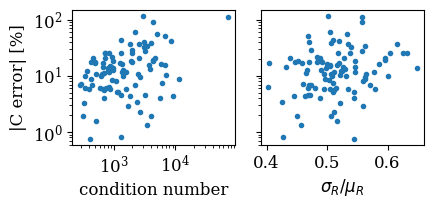

In [155]:
results = runsim(100, 100)
_ = plotsim(results)

Running more charge points seems to improve the error.

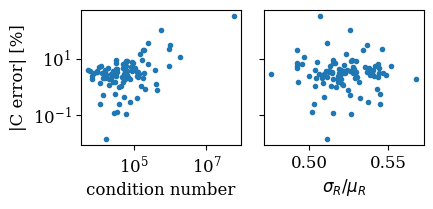

In [157]:
results = runsim(100, 1000)
_ = plotsim(results)

There is a weak correlation between the condition number and the capacitance error.  Even with 1000 points on the sphere, the error is quite large.  Averged over 100 simulations, the mean error is 8.8%.  

In [159]:
print("mean absolute error = {:0.2f}".format(np.abs(results['err']).mean()))

mean absolute error = 8.81


This error is comparable to the $-4.9$% capacitance error seen above with a 3200-point simulation using points non-randomly located around $\theta$ and $\phi$ using the usual sphere parameterization.

The lowest condition number was

In [164]:
results['cn'].min()

5488.226041801699

and the capacitance percent error was

In [165]:
results['err'][results['cn'] == results['cn'].min()][0]

-4.139117000469539

# Conclusion

Using randomly-located charge points does not significantly improve the capacitance error.  The capacitance error is not strongly correlated with the $R$ matrix condition number or the relative narrowness of distribution governing nearest-neighbor distances.

Using the boundary element method, getting a capacitance error below 1% is going to take 10,000's of points.  Ouch!